# Practica 2

_Autores_

-   Palmer Pérez, Rubén

## Descipción de la practica

Este proyecto se basa en el análisis del conjunto de datos [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), abordando diversas problemáticas utilizando [Convolutional Neural Networks (CNN)](<(https://en.wikipedia.org/wiki/Convolutional_neural_network)>).

### Tareas asignadas

1. Clasificación Perros vs. Gatos:

    - Implementación de clasificación para distinguir entre perros y gatos.
    - Utilización de una red creada manualmente y otra preentrenada.

2. Clasificación de la Raza:

    - Clasificar la raza de los animales presentes en el conjunto de datos.

3. Detección de la Posición de la Cabeza:

    - Investigación y aplicación de técnicas para identificar la posición de la cabeza en las imágenes.

4. Segmentación del Animal:

    - Implementación de un sistema para segmentar el objeto animal en las imágenes proporcionadas.

En este documento se examina el proceso de aprendizaje, procesamiento de datos y pruebas que han llevado a la solución de los dos primeros puntos


## Paquetes


In [1]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import warnings

warnings.filterwarnings("ignore")

import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import random
from collections import Counter

from os import path, listdir
from torchvision import transforms
from torchview import draw_graph
from torch.utils.data import DataLoader
from skimage import filters, img_as_ubyte, color, img_as_float
from skimage.transform import rotate
from skimage.io import imread, imsave
from skimage.util import random_noise
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from functools import reduce
from operator import sub
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from CatDogDataset import CatDogDataset
from network import CatDogNet, CatDogResnet34, CatDogResnet50

## Preparación del entorno


In [2]:
CONFIG = {
    "DEVICE": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "IMAGE_SIZE": (128, 128),
    "DATA_PATH": path.join(path.abspath(path.pardir), "data", "images"),
    "SEED": 27,
    "MODEL": {"EPOCH": 15, "LEARNING_RATE": 0.00001}
}

random.seed(CONFIG.get("SEED"))

Adicionalmente, eliminaremos posibles artefactos de previas ejecuciones


In [3]:
files_to_remove = (
    os.path.join(folder, file)
    for folder, _, files in os.walk(path.join(CONFIG.get("DATA_PATH")))
    for file in files
    if "generated" in file
)

any(map(os.remove, files_to_remove))

False

## Datos

El conjunto de datos establece lo siguiente en los documentos adjuntos de etiquetado

_Todas las imágenes con la 1ª letra en mayúscula son imágenes de gatos, mientras que las imágenes con la primera letra en minúscula son imágenes de perros._

Gracias a que el nombre del archivo tambien indica la raza del animal, utilizaremos el nombre de cada imagen para generar un `dataframe` que contenga el `path` de cada imagen y las etiquetas necesarias. Adicionalmente comentar que, aunque se podría directamente codificar las etiquetas para su futuro uso, se mantendrá el uso de etiquetas con una mayor carga semántica; evitando los [números mágicos](<https://en.wikipedia.org/wiki/Magic_number_(programming)>) fuera del estudio de los datos

In [4]:
image_files = [
    path.join(CONFIG.get("DATA_PATH"), file)
    for file in listdir(CONFIG.get("DATA_PATH"))
    if file.endswith(".jpg")
]

labels = pd.DataFrame(
    {
        "image_name": image_files,
        "species": [
            "cat" if path.basename(file)[0].isupper() else "dog" for file in image_files
        ],
        "breed": [
            "_".join(path.basename(file).split("_")[:-1]).lower()
            for file in image_files
        ],
    }
)

labels

,image_name,species,breed
0,c:\Users\Eden\Documents\projects\AA_Practica2\...,cat,abyssinian
1,c:\Users\Eden\Documents\projects\AA_Practica2\...,cat,abyssinian
2,c:\Users\Eden\Documents\projects\AA_Practica2\...,cat,abyssinian
3,c:\Users\Eden\Documents\projects\AA_Practica2\...,cat,abyssinian
4,c:\Users\Eden\Documents\projects\AA_Practica2\...,cat,abyssinian
...,...,...,...
7385,c:\Users\Eden\Documents\projects\AA_Practica2\...,dog,yorkshire_terrier
7386,c:\Users\Eden\Documents\projects\AA_Practica2\...,dog,yorkshire_terrier
7387,c:\Users\Eden\Documents\projects\AA_Practica2\...,dog,yorkshire_terrier
7388,c:\Users\Eden\Documents\projects\AA_Practica2\...,dog,yorkshire_terrier


Comentar que, explorando los diferentes tipos de imagenes manualmente, se han encontrado diferentes extensiones. Con el objetivo de simplificar el proceso de procesamiento de imagenes, solo se han tenido en cuenta las imagenes con extensión `.jpg`


### Analisis

En este apartado, tiene como objetivo examinar las etiquetas e imágenes antes de proceder a su carga. Se busca, especialmente, la identificación de patrones y desbalancesen las clasificaciones. Para ello, se usara un conjunto de calculos imperativos y exploración grafica.

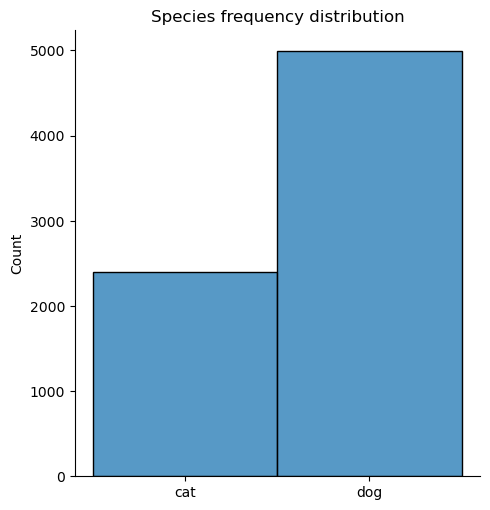

In [5]:
sns.displot(
    labels["species"].values,
)
plt.title("Species frequency distribution")
plt.show()

La visualización revela un notable desbalance entre las especies, viendo que hay aproximadamente el doble de perros en comparación con los gatos. En este escenario, nos hemos planteado tres posibles soluciones:

-   **Permanecer en este estado:** Existe el riesgo de que el modelo realice predicciones erróneas basñandose únicamente en la cantidad de datos. Por ejemplo, en una situación extrema, si hay 1 gato y 99 perros, el modelo etiquetaría todas las imágenes como perros, ya que tiene un 99% de probabilidades de acertar.
-   **Downsample**: Eliminar aleatoriamente observaciones de los perros hasta igualar el número de gatos; posiblemente reduciendo la precisión de acierto ante las predicciones de los perros
-   **Upsample**: Emplear técnicas de [aumento de datos](https://en.wikipedia.org/wiki/Data_augmentation) para generar nuevas imágenes de gatos hasta igualar la el número de perros; posiblemente creando `overfitting`


En este especifico caso, y con fines academicos, se ha optado por generar imágenes adicionales de gatos

Asi pues, procedemos a la distribución de razas:

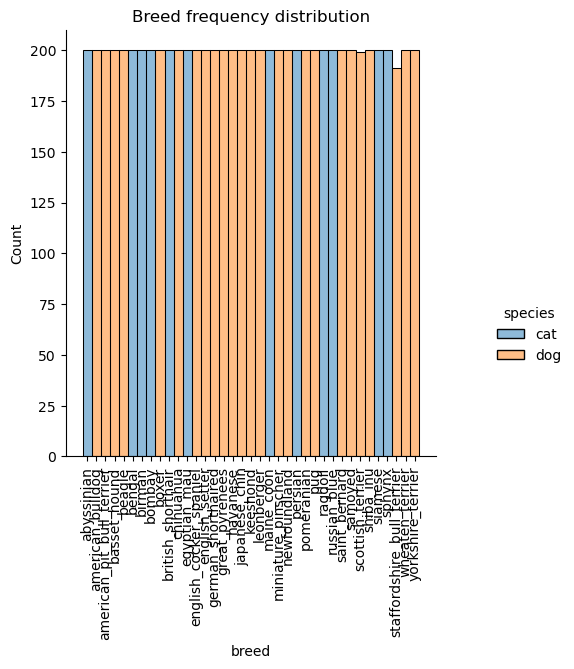

In [6]:
sns.displot(data=labels, x="breed", hue="species")
plt.title("Breed frequency distribution")
plt.xticks(rotation=90)
plt.show()

La distribución de razas se mantiene generalmente estable, a excepción de `stanffordshire_bull_terrier` y `scotish_terrier`, las cuales tienen ligeramente menos datos. Así pues, no será necesario realizar modificaciones en los datos en relación a la especie

## Gatos VS Perros: Clasificación

### Aumento de datos

Como se ha mencionado previamente, la falta de observaciones de gatos genera un desbalance de fequencia. Para mitigar dicho impacto, se generarán nuevas imágenes de gatos mediante la aplicación de un conjunto aleatorio de transformaciones. Al concluir este proceso, se espera obtener un conjunto adicional de imágenes de gatos que, idealmente, sean suficientemente diveras como para reducir la posibilidad que el modelo sufra de `overfitting` o al menos reducir su efecto.


In [7]:
manipulations = [
    lambda img: rotate(img, random.randint(0, 360), mode="wrap"),
    lambda img: random_noise(img, seed=CONFIG.get("SEED"), mode="s&p", amount=0.1),
    lambda img: random_noise(img, seed=CONFIG.get("SEED"), mode="gaussian", var=0.01),
    lambda img: img[::-1, ::-1],
    lambda img: filters.gaussian(img, sigma=1),
]

PROPORTIONAL_MANIPULATION_AMOUNT = 2

cat_data = labels[labels["species"] == "cat"]["image_name"].to_list()

amount_of_cats = abs(sub(*labels["species"].value_counts().values))

records = []

for i in range(amount_of_cats):

    random_manipulations = random.sample(
        manipulations,
        random.randint(1, len(manipulations) // PROPORTIONAL_MANIPULATION_AMOUNT),
    )

    choice = random.choice(cat_data)
    img = reduce(
        lambda img, manipulation: manipulation(img),
        random_manipulations,
        imread(choice),
    )

    try:
        imsave(
            path.join(path.join(CONFIG.get("DATA_PATH")), f"generated{i}.jpg"),
            img_as_ubyte(img),
        )
    except:
        print("Had some error with image", choice, "skiping...")
        continue

    records.append(
        {
            "image_name": path.join(
                path.join(CONFIG.get("DATA_PATH")), f"generated{i}.jpg"
            ),
            "species": "cat",
            "breed": "_".join(path.basename(choice).split("_")[:-1]).lower(),
        }
    )

labels_cat_dogs = pd.concat([labels, pd.DataFrame(records)])

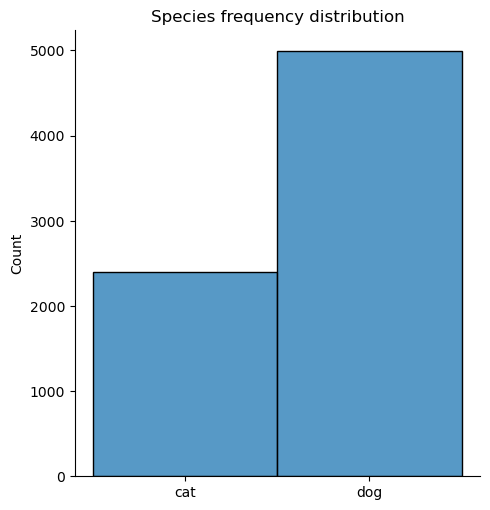

In [28]:
sns.displot(
    labels_cat_dogs["species"].values,
)
plt.title("Species frequency distribution")
plt.show()

Ahora pues, tenemos un conjunto de datos balanceados con respecto a la especie de los animales.

### `Finetunning` de la media y la desviación estandar

Al aplicar las transformaciones, se suele normalizar los datos de entrada para reducir la posible contribución de errores por valores extremos. Para ello, sse suelen usar los siguientes valores:

-   media: [0.485, 0.456, 0.406]
-   std: [0.229, 0.224, 0.225]

Que son los los obtenidos por [ImageNet](https://image-net.org/). Sin embargo, y por razones académicas, se calcularán dichos valores especificamente para nuestro conjunto de datos.


In [9]:
def calculate_mean_std(paths: list[str]) -> tuple[int, int]:
    mean = np.zeros(3)
    std = np.zeros(3)

    for path in paths:
        try:
            img = imread(path)
            img = img_as_float(img)
            if len(img.shape) == 2 or (len(img.shape) == 3 and img.shape[2] == 1):
                img = color.gray2rgb(img)
            img = img.transpose((2, 0, 1))
            img = img.reshape(3, -1)
            mean += img.mean(axis=1)
            std += img.std(axis=1)
        except:
            print("failure on image", path, " skiping...")
            continue

    mean /= len(paths)
    std /= len(paths)

    return mean.tolist(), std.tolist()


norm_data = calculate_mean_std(labels_cat_dogs["image_name"])
print(norm_data)

[[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]

Los resultados, siendo extremadamente parecidos a los de ImageNet, nos reafirman que estamos cerca del dominio de resultados para imagenes genericas y que estos valores no son más que una especialización para este entrenamiento


In [10]:
transform = transforms.Compose(
    [
        transforms.Resize(CONFIG.get("IMAGE_SIZE")),
        transforms.ToTensor(),
        transforms.Normalize(*norm_data),
    ]
)

### Codificación de las etiquetas

Como ya se mencionó previamante, la etiquetas que actualmente poseemos están cargadas semánticamente. Sin embargo, para ofrecerlas como `target` para el modelo, será necesaria codificarlas numericamente:


In [11]:
species_encoder = LabelEncoder()
labels_cat_dogs["encoded_species"] = species_encoder.fit_transform(
    labels_cat_dogs["species"]
)

### Entrenamiento, validación y prueba

En este caso usaremos la división 70/15/15 encontrados [aquí](https://www.v7labs.com/blog/train-validation-test-set).


In [12]:
rest_data, train_data, rest_pred, train_pred = train_test_split(
    labels_cat_dogs["image_name"].values,
    labels_cat_dogs["encoded_species"].values,
    test_size=0.7,
    random_state=CONFIG.get("SEED"),
)

val_data, test_data, val_pred, test_pred = train_test_split(
    rest_data, rest_pred, test_size=0.5, random_state=CONFIG.get("SEED")
)

Adicionalmente, se ha creado una implementación personalizada basada en el modulo [Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) de Pytorch, permitiendonos un uso sencillo e intuitivo de los `DataLoader`, encargados de ofrecer los datos al modelo aplicando las transformaciones especificadas previamente


In [13]:
train_dl = DataLoader(CatDogDataset(train_data, train_pred, transform), batch_size=100)
val_dl = DataLoader(CatDogDataset(val_data, val_pred, transform), batch_size=100)
test_dl = DataLoader(CatDogDataset(test_data, test_pred, transform), batch_size=100)

### Especificación del modelo

La CNN diseñada tiene como objetivo la clasificación binaria entre gatos y perros. Para ello se ha implementado la siguiente arquitectura:

-   **Bloque convolucional**: un conjunto de bloques que aplican `Convolution2D`, `batch normalization`, `ReLU` y `MaxPool2D`. tiene como objetivo encargarse de aplicr dichas convoluciones reduciendo al maximo el ruido y los parametros
-   **Dropout**: Para reducir la posibilidad de `overfitting` con el tradeback de posiblemente no llegar a su maximo nivel de predicción
-   **1Dimensional**: Un conjunto de capas que, un vez transformado la matriz en un vector, aplican capas lineales

A continuación se podrá ver la representación grafica de la arquitectura usando [torchview](https://github.com/mert-kurttutan/torchview)



(dot.exe:51616): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


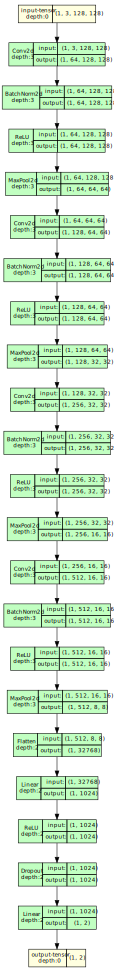

In [14]:
draw_graph(CatDogNet(2), input_size=(1, 3, 128, 128), device="meta").visual_graph

### Entrenamiento

Finalmente, entrenaremos el modelo un total de 15 epochs. Adicionalmente, y con el objetivo de apreciar si el modelo ha sufrido de overfitting, se visualizará las `time series` del `accuracy` del entrenamiento y la validación


In [15]:
def train(model, optimizer, criterion, epochs, train_loader, validation_loader):
    model.train()
    train_acc = []
    valid_acc = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0

        for data, label in train_loader:
            data = data.to(CONFIG.get("DEVICE"))
            label = label.to(CONFIG.get("DEVICE"))

            output = model(data)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss / len(train_loader)

        train_acc.append(epoch_accuracy)
        print(
            "Epoch : {}, train accuracy : {}, train loss : {}".format(
                epoch + 1, epoch_accuracy, epoch_loss
            )
        )

        # Validation
        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in validation_loader:
                data = data.to(CONFIG.get("DEVICE"))
                label = label.to(CONFIG.get("DEVICE"))

                val_output = model(data)
                val_loss = criterion(val_output, label)
                # No optimizer as we don't want to change the weights

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(validation_loader)
                epoch_val_loss += val_loss / len(validation_loader)

            valid_acc.append(epoch_val_accuracy)
            print(
                "Epoch : {}, val_accuracy : {}, val_loss : {}".format(
                    epoch + 1, epoch_val_accuracy, epoch_val_loss
                )
            )
    model.eval()
    return list(map(float, train_acc)), list(map(float, valid_acc))


def train_val_plot(train, val):
    plt.plot(range(len(train)), train, label="Entrenamiento")
    plt.plot(range(len(val)), val, label="Validación")

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(
        "Accuracy del conjunto de entrenamiento y validación con respecto al tiempo"
    )

    plt.legend()

    plt.show()


model = CatDogNet(2)

if path.exists(path.join(path.dirname(CONFIG.get("DATA_PATH")), "model")):
    print("Found model state dict, loading ...")
    model.load_state_dict(
        torch.load(path.join(path.dirname(CONFIG.get("DATA_PATH")), "model"))
    )
else:
    model = model.to(CONFIG.get("DEVICE"))
    train_acc, valid_acc = train(
        model=model,
        optimizer=optim.Adam(
            params=model.parameters(), lr=CONFIG.get("MODEL").get("LEARNING_RATE")
        ),
        criterion=torch.nn.CrossEntropyLoss(),
        epochs=CONFIG.get("MODEL").get("EPOCH"),
        train_loader=train_dl,
        validation_loader=val_dl,
    )

    torch.save(
        model.state_dict(),
        path.join(path.dirname(CONFIG.get("DATA_PATH")), "model"),
    )

    train_val_plot(train_acc, valid_acc)

Found model state dict, loading ...


Podemos observar como, con el tiempo, el conjunto de validación va perdiendo poco a poco el incremento de `accuracy`. Un aumento de su conjunto de datos podría mejorar dicho aumento. Importantemente, podemos apreciar como el modelo no sufre de un `overfitting` especialmente agresivo. A continuación, mediante el uso del conjunto de test, se evaluará cuan buenas son las predicciones.


0.8173148135344187


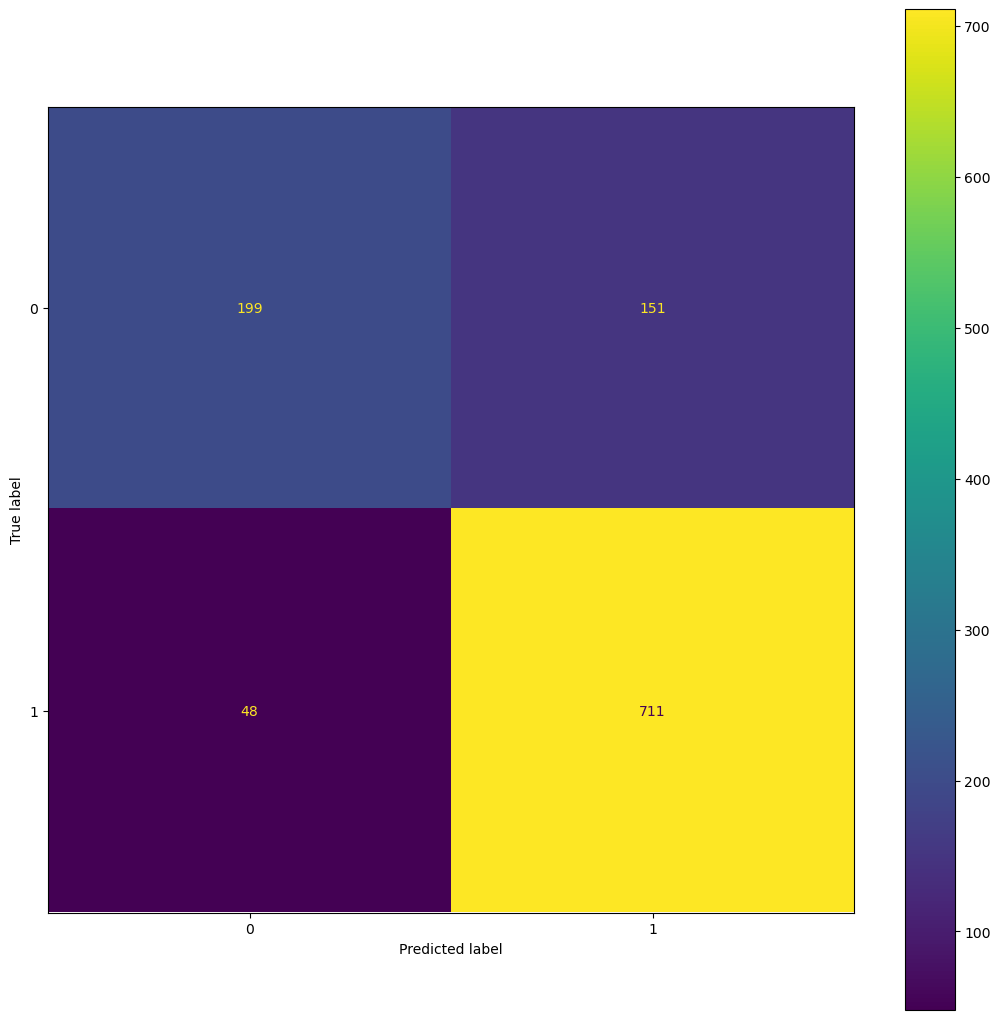

In [16]:
def test(model, test_loader, device):
    predictions = []
    real_labels = []

    overall_acc = 0
    for image, label in test_loader:
        image, label = [data.to(device) for data in (image, label)]

        test_output = model(image).argmax(dim=1)
        predictions.extend(list(map(int, test_output)))
        real_labels.extend(list(map(int, label)))
        acc = float((test_output == label).float().mean())
        overall_acc += acc / len(test_dl)


    print(overall_acc)

    cm = confusion_matrix(real_labels, predictions)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    _, ax = plt.subplots(figsize=(13, 13))
    disp.plot(ax=ax)
    plt.show()



test(model, test_dl, CONFIG.get("DEVICE"))

Finalmente, podemos observar como el modelo ha podido generalizar la idea de `gato` o `perro`, ya que la `accuracy` obtenida es, relativamente, alta. Adicionalmente, podemos representar graficamante, para que el lector pueda apreciar, un conjunto de imagenes con sus respectivas predicciones


tensor([1])
tensor([1])
tensor([1])
tensor([1])


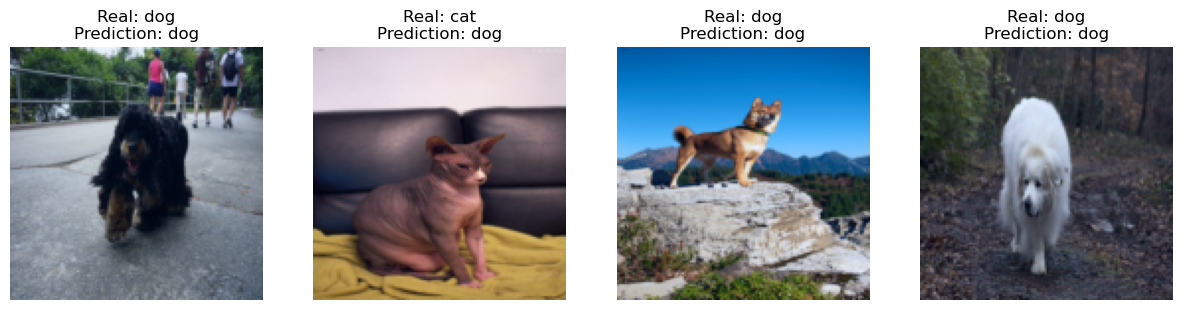

In [44]:
def show_predictions(model, data_loader, label_encoder, n_images=4):
    test_cat_dog_pairs = list(zip(*next(iter(data_loader))))

    random_images = random.sample(test_cat_dog_pairs, n_images)

    _, axs = plt.subplots(1, n_images, figsize=(15, 10))

    for i, (image, label) in enumerate(random_images):
        prediction = model(torch.unsqueeze(image, 0)).argmax(dim=1)
        image = image.detach().cpu().numpy()

        if image.shape[0] == 1:
            image = np.repeat(image, 3, axis=0)

        image = (image - image.min()) / (image.max() - image.min())

        axs[i].imshow(np.transpose(image, (1, 2, 0)), vmin=0, vmax=1)
        axs[i].set_title(
            f"Real: {label_encoder.inverse_transform([label])[0]}\nPrediction: {label_encoder.inverse_transform(prediction)[0]}"
        )
        axs[i].axis("off")

    plt.show()


show_predictions(model, test_dl, species_encoder)

### Resnet34

Se usara el modelo [Resnet34](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet34.html) para comparar los anteriores resultados. Se entrenará con los mismos datos, transformaciones, criterio y optimizador por lo que, esencialmente, solo estamos cambiando el modelo usado. Para solucionar el problema de dimensionalidad del modelo original, se ha eliminado la ultima capa y remplazado por la siguiente estructura:

-   Flatten()
-   Linear(512, 512)
-   ReLU()
-   Dropout(0.5)
-   Linear(512, num_classes)

En este caso el `num_classes` es 2 ya que es un problema de clasificación binaria. Esta pues es la estructura final:



(dot.exe:51928): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


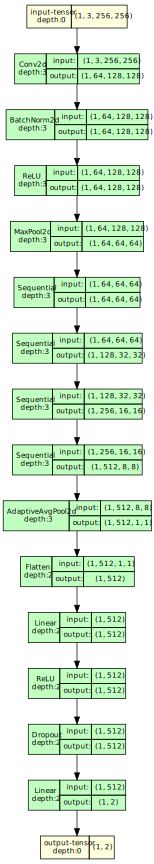

In [18]:
draw_graph(CatDogResnet34(2), input_size=(1, 3, 256, 256), device="meta").visual_graph

Finalmente, entrenamos el modelo. Comentar que, debido a que usamos los pesos originales de resnet34, el proceso de entrenamiento será mucho más rápido de lo esperado.


In [19]:
resnet34_model = CatDogResnet34(2)
if path.exists(path.join(path.dirname(CONFIG.get("DATA_PATH")), "resnet34_model")):
    print("Found model state dict, loading ...")
    resnet34_model.load_state_dict(
        torch.load(path.join(path.dirname(CONFIG.get("DATA_PATH")), "resnet34_model"))
    )
else:
    resnet34_model = resnet34_model.to(CONFIG.get("DEVICE"))
    resnet34_train_acc, resnet34_valid_acc = train(
        model=resnet34_model,
        optimizer=optim.Adam(
            params=resnet34_model.parameters(),
            lr=CONFIG.get("MODEL").get("LEARNING_RATE"),
        ),
        criterion=torch.nn.CrossEntropyLoss(),
        epochs=CONFIG.get("MODEL").get("EPOCH"),
        train_loader=train_dl,
        validation_loader=val_dl,
    )

    torch.save(
        resnet34_model.state_dict(),
        path.join(path.dirname(CONFIG.get("DATA_PATH")), "resnet34_model"),
    )

    train_val_plot(resnet34_train_acc, resnet34_valid_acc)

Found model state dict, loading ...


**REPLACE**

Por los logs podemos apreciar como el modelo ha llegado al 99% de `acuracy` en el modelo de entrenamiento aun que solo un 60% en el de validación y graficamente podemos apreciar el proceso de aprendizaje de resnet. Curiosamente el conjunto de validación no ha subido sustancialmente durante este proceso; posiblemente generado por un `overfitting` del conjunto de entrenamiento o la falta dedatos con respecto al conjunto de validación. Para responder a esta incertidumbre visualizaremos un conjunto de imagenes, como previamente se ha ejecutado, con la etiqueta real y su predicción


0.975740745663643


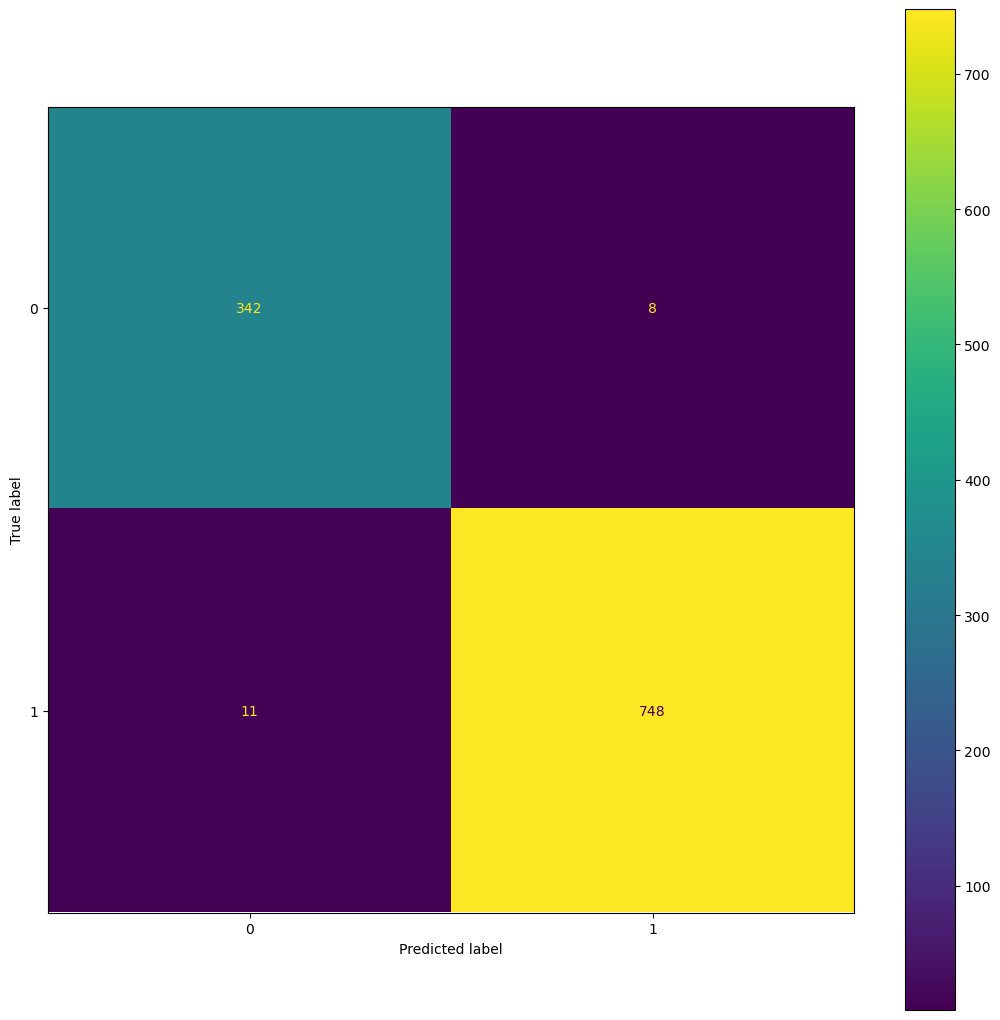

tensor([1])
tensor([1])
tensor([1])
tensor([1])


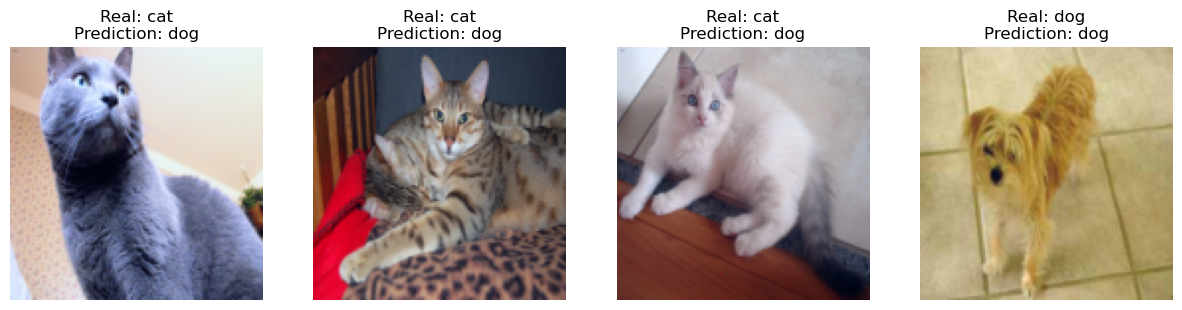

In [48]:
test(resnet34_model, test_dl, CONFIG.get("DEVICE"))

show_predictions(resnet34_model, test_dl, species_encoder)

El modelo tiene una `accuracy` del 63%, aumentando las sospechas que el modelo ha sufrido de `overfitting`, ya sea por una falta de datos en el conjunto de validación o por la arquitectura del modelo.

Finalmente podemos concluir que, bajo los datos usados, optimizador y transformaciones aplicadas, el modelo presonalizado ofrece mejores resultados


## Detección de razas


Para la detección de razas será necesario cambiar el target y la estructura del modelo. Inicialmente, y al igual que con la especies, se codifican las etiquetas que serán el `target` del entrenamiento mediante un `LabelEncoder`. Esto nos permitirá en un futuro invertir la transformación facilmente


In [21]:
breed_encoder = LabelEncoder()
labels["encoded_breed"] = breed_encoder.fit_transform(labels["breed"])

Al evitar de la aumentación de datos, es necesario recalcular la media y la desviación estandar para la transformación.


In [22]:
breed_transform = transforms.Compose(
    [
        transforms.Resize(CONFIG.get("IMAGE_SIZE")),
        transforms.ToTensor(),
        transforms.Normalize(*calculate_mean_std(labels["image_name"])),
    ]
)

Adicionalmente, al no usar aumento de datos, se usará el dataset original. Por ende, se creará un nuevo `split` de datos


In [23]:
rest_breed_data, train_breed_data, rest_breed_pred, train_breed_pred = train_test_split(
    labels["image_name"].values,
    labels["encoded_breed"].values,
    test_size=0.7,
    random_state=CONFIG.get("SEED"),
)

val_breed_data, test_breed_data, val_breed_pred, test_breed_pred = train_test_split(
    rest_breed_data, rest_breed_pred, test_size=0.5, random_state=CONFIG.get("SEED")
)

breed_train_dl = DataLoader(
    CatDogDataset(train_breed_data, train_breed_pred, breed_transform), batch_size=100
)
breed_val_dl = DataLoader(
    CatDogDataset(val_breed_data, val_breed_pred, breed_transform), batch_size=100
)
breed_test_dl = DataLoader(
    CatDogDataset(test_breed_data, test_breed_pred, breed_transform), batch_size=100
)

Seguidamente, al necesitar ahora una salida por cada raza, debemos instanciar los modelos con `num_classes = 37`, que es la cantidad de diferentes razas que poseemos actualmente en el conjunto de datos. Comentar que, por interés académico, se ha decidido usar [Resnet50](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html); con el uso de sus pesos originales y cambiando la ultima capa por la estructura previamente mostrada.



(dot.exe:67836): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


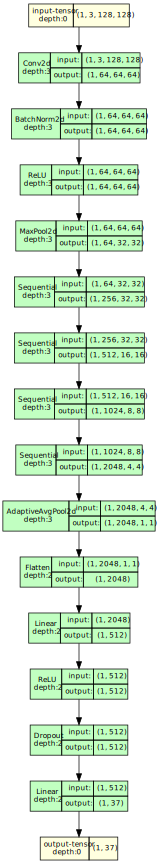

In [24]:
draw_graph(CatDogResnet50(37), input_size=(1, 3, 128, 128), device="meta").visual_graph

Finalmente, entrenamos el modelo con los datos


In [25]:
resnet50_model = CatDogResnet50(37)

if path.exists(path.join(path.dirname(CONFIG.get("DATA_PATH")), "resnet50_model")):
    print("Found model state dict, loading ...")
    resnet50_model.load_state_dict(
        torch.load(path.join(path.dirname(CONFIG.get("DATA_PATH")), "resnet50_model"))
    )
else:
    resnet50_model = resnet50_model.to(CONFIG.get("DEVICE"))
    resnet50_train_acc, resnet50_valid_acc = train(
        model=resnet50_model,
        optimizer=optim.Adam(
            params=resnet50_model.parameters(),
            lr=CONFIG.get("MODEL").get("LEARNING_RATE"),
        ),
        criterion=torch.nn.CrossEntropyLoss(),
        epochs=CONFIG.get("MODEL").get("EPOCH"),
        train_loader=breed_train_dl,
        validation_loader=breed_val_dl,
    )

    torch.save(
        resnet50_model.state_dict(),
        path.join(path.dirname(CONFIG.get("DATA_PATH")), "resnet50_model"),
    )

    train_val_plot(resnet50_train_acc, resnet50_valid_acc)

Found model state dict, loading ...


0.8362963000933329


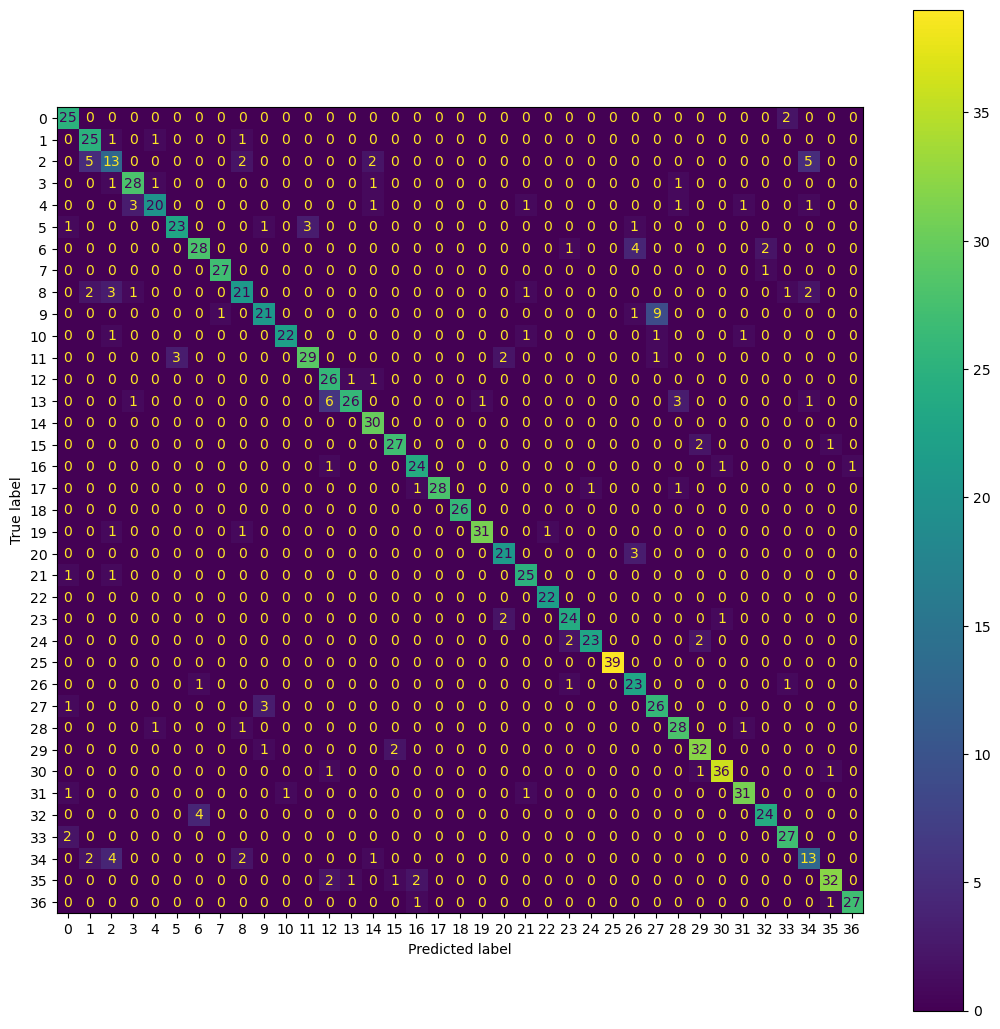

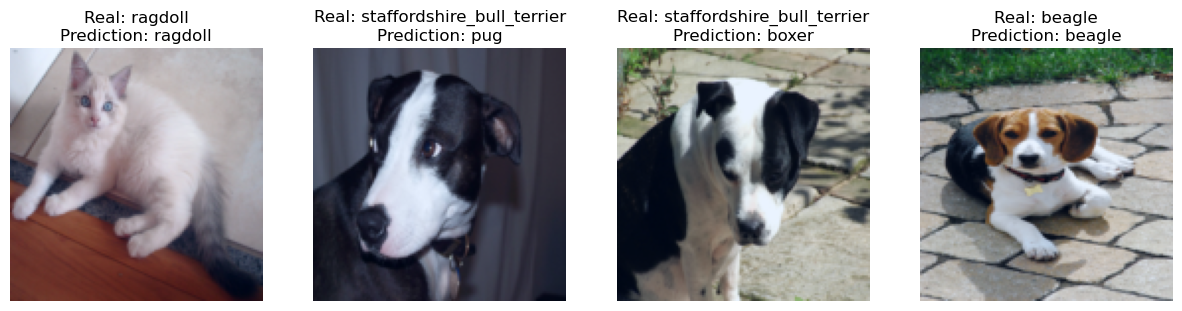

In [30]:
test(resnet50_model, breed_test_dl, CONFIG.get("DEVICE"))

show_predictions(resnet50_model, breed_test_dl, breed_encoder)

Para una visión mas exhaustiva, se visualizará la matriz de correlación para todo el conjunto de test
